In [1]:
from pyspark import SparkConf
from pyspark import SparkContext

In [2]:
import socket 
def get_Host_name_IP(): 
    try: 
        host_name = socket.gethostname() 
        host_ip = socket.gethostbyname(host_name) 
        print("Hostname :  ",host_name) 
        print("IP : ",host_ip) 
    except: 
        print("Unable to get Hostname and IP") 
  
# Driver code 
get_Host_name_IP() #Function call

Hostname :   DESKTOP-9AL8KCH
IP :  192.168.1.34


In [3]:
import pyspark as ps
from pyspark.sql.functions import col, explode
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator , ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import udf, col, when
import numpy as np
import findspark
findspark.init("C:\BigDataLocal\spark-2.4.7-bin-hadoop2.7")

In [4]:
#to show all predicte book image
from IPython.display import Image
from IPython.display import display
#create  a spark session 
#create a spark context
spark=ps.sql.SparkSession.builder.master("local").appName("Demo").getOrCreate()
sc=spark.sparkContext
sqlContext=SQLContext(sc)

In [6]:
#import libraries
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
# plotly
# import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True) #offline modela ilgili
import plotly.graph_objs as go
from wordcloud import WordCloud
# matplotlib
import matplotlib.pyplot as plt

import os

# Any results you write to the current directory are saved as output.

In [7]:
book_tags = pd.read_csv('dataset/book_tags.csv',encoding="Latin1")
books = pd.read_csv('dataset/books.csv', encoding="Latin1")
ratings = pd.read_csv('dataset/ratings.csv',encoding="Latin1")
tags = pd.read_csv('dataset/tags.csv', encoding="Latin1")
to_read = pd.read_csv('dataset/to_read.csv',encoding="Latin1")

In [8]:
ratings_df = spark.read.csv('dataset/ratings.csv',header=True,  inferSchema=True)
ratings_df.printSchema()

books_df=spark.read.csv('dataset/books.csv',header=True, inferSchema=True)

root
 |-- book_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [9]:
ratings_df.show(5)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
+-------+-------+------+
only showing top 5 rows



In [10]:
books.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [11]:
books.describe()

,id,book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [12]:
num_book=books.count()
print('Number Of Books: ', num_book)

Number Of Books:  id                           10000
book_id                      10000
best_book_id                 10000
work_id                      10000
books_count                  10000
isbn                          9300
isbn13                        9415
authors                      10000
original_publication_year     9979
original_title                9415
title                        10000
language_code                 8916
average_rating               10000
ratings_count                10000
work_ratings_count           10000
work_text_reviews_count      10000
ratings_1                    10000
ratings_2                    10000
ratings_3                    10000
ratings_4                    10000
ratings_5                    10000
image_url                    10000
small_image_url              10000
dtype: int64


In [13]:
books.shape

(10000, 23)

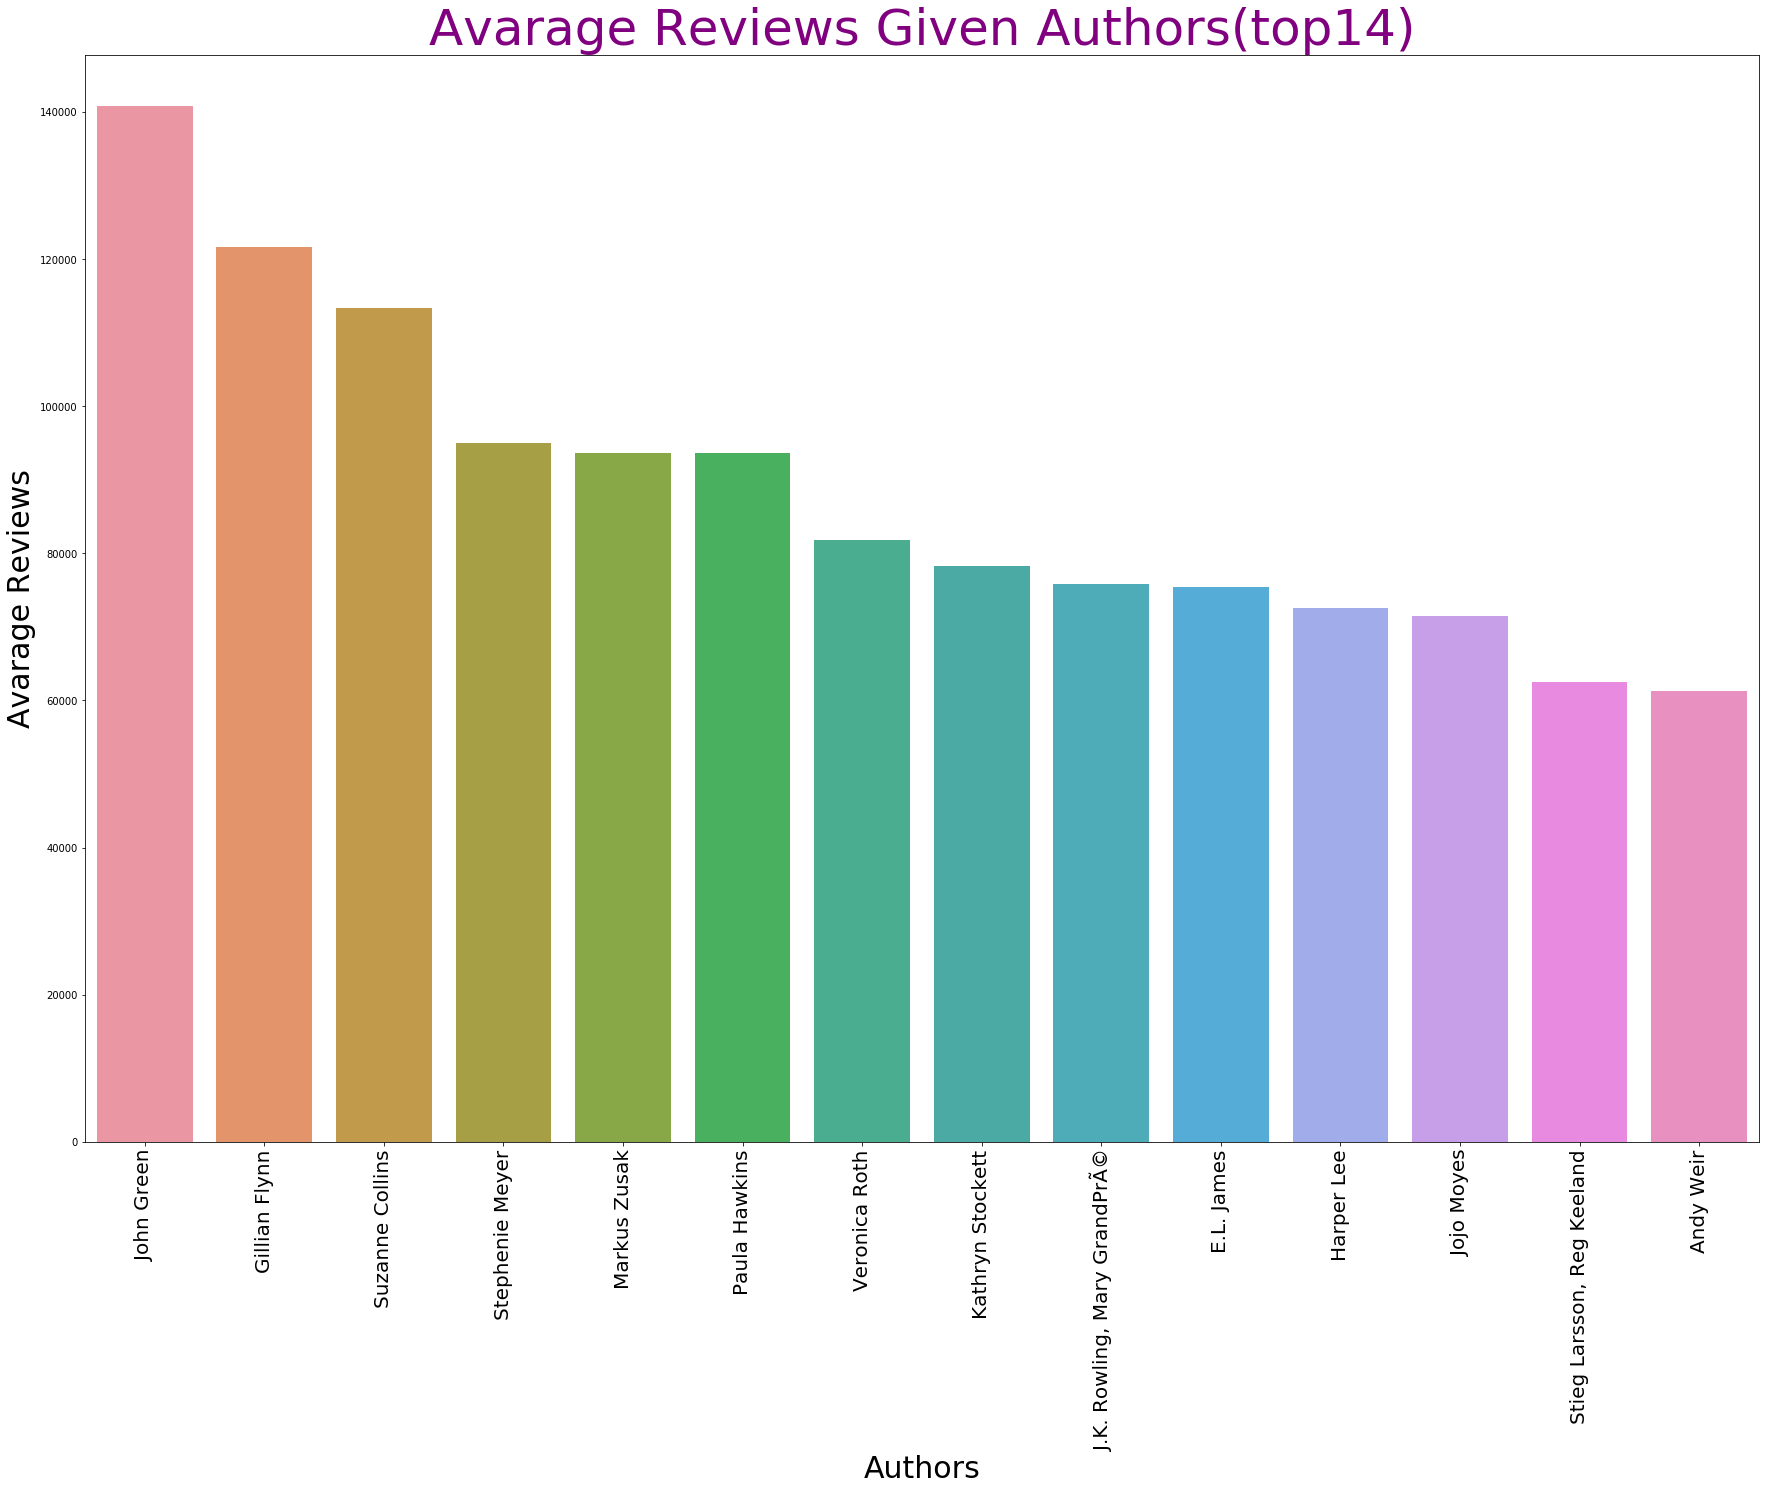

In [14]:
# the avarage reviews that given authors on goodreads.
df = books.work_text_reviews_count>60000
books_newdata2=books[df]
melted_books2= pd.melt(frame=books_newdata2,id_vars='authors',value_vars='work_text_reviews_count')
reviews_list= list(melted_books2['authors'].unique())
author_reviews_ratio=[]

for i in reviews_list:
    x= melted_books2[melted_books2['authors']==i]
    author_reviews_ratio_rate=sum(x.value)/len(x)
    author_reviews_ratio.append(  author_reviews_ratio_rate)

data = pd.DataFrame({'reviews_list':reviews_list,'author_reviews_ratio':author_reviews_ratio})
new_index = (data['author_reviews_ratio'].sort_values(ascending=False)).index.values
sorted_data2 = data.reindex(new_index)

#visualization
plt.figure(figsize=(30,20))
sns.barplot(x=sorted_data2['reviews_list'],y=sorted_data2['author_reviews_ratio'])
plt.xticks(rotation= 90,size='20')
plt.xlabel('Authors',size='30')
plt.ylabel('Avarage Reviews',size='30')
plt.title('Avarage Reviews Given Authors(top14)',color='purple',size='50')
plt.show()

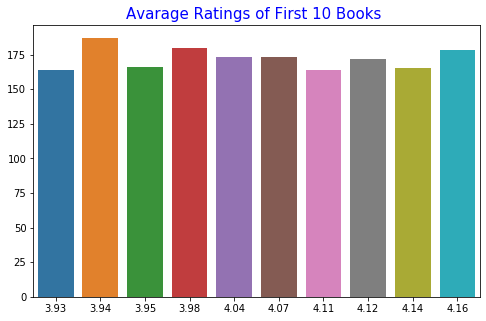

In [15]:
data3=books.head(6)
sta = books.average_rating.value_counts().index[:10]  
plt.figure(figsize = (8,5))
sns.barplot(x=sta,y =books.average_rating.value_counts().values[:10]) 
plt.title('Avarage Ratings of First 10 Books ',color = 'blue',fontsize=15)
plt.show()

In [16]:
books2= books.drop(columns=['work_id','id','book_id','best_book_id','best_book_id','isbn13','original_publication_year',"image_url","small_image_url"])

In [17]:
books2.corr()

,books_count,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
books_count,1.000000,-0.069888,0.324235,0.333664,0.198698,0.225763,0.334923,0.383699,0.349564,0.279559
average_rating,-0.069888,1.000000,0.044990,0.045042,0.007481,-0.077997,-0.115875,-0.065237,0.036108,0.115412
ratings_count,0.324235,0.044990,1.000000,0.995068,0.779635,0.723144,0.845949,0.935193,0.978869,0.964046
work_ratings_count,0.333664,0.045042,0.995068,1.000000,0.807009,0.718718,0.848581,0.941182,0.987764,0.966587
work_text_reviews_count,0.198698,0.007481,0.779635,0.807009,1.000000,0.572007,0.696880,0.762214,0.817826,0.764940
ratings_1,0.225763,-0.077997,0.723144,0.718718,0.572007,1.000000,0.926140,0.795364,0.672986,0.597231
ratings_2,0.334923,-0.115875,0.845949,0.848581,0.696880,0.926140,1.000000,0.949596,0.838298,0.705747
ratings_3,0.383699,-0.065237,0.935193,0.941182,0.762214,0.795364,0.949596,1.000000,0.952998,0.825550
ratings_4,0.349564,0.036108,0.978869,0.987764,0.817826,0.672986,0.838298,0.952998,1.000000,0.933785
ratings_5,0.279559,0.115412,0.964046,0.966587,0.764940,0.597231,0.705747,0.825550,0.933785,1.000000


In [18]:
training_df, validation_df =ratings_df.randomSplit([.7,.3])

In [19]:
iteration=(2,5,8)
rank=(2,5,8)
Lambda=(0.1,0.01)
tmp=1
for i in Lambda:
    for j in rank:
        for k in iteration:
            count=+1
            als = ALS( seed=5036,maxIter=k ,regParam=i ,rank=j,userCol="user_id",itemCol="book_id",ratingCol="rating")
            model=als.fit(training_df)
            predictions=model.transform(validation_df)
            new_predictions=predictions.filter(col('prediction') != np.nan)
            evaluator=RegressionEvaluator(metricName="mse", labelCol="rating" , predictionCol="prediction")
            mse=evaluator.evaluate(new_predictions)
            print( "Square error "+ str(mse)+ " rank :" + str(j)+ " Lambda :" + str(i)+ " iteration :" + str(k) )
            if mse<tmp:
                tmp=mse
                values=(i,j,k)

print(tmp , values)

Square error 10.432807399281522 rank :2 Lambda :0.1 iteration :2
Square error 0.9282566297757835 rank :2 Lambda :0.1 iteration :5
Square error 0.7910170953113383 rank :2 Lambda :0.1 iteration :8
Square error 5.316616516380464 rank :5 Lambda :0.1 iteration :2
Square error 0.9214222203814534 rank :5 Lambda :0.1 iteration :5
Square error 0.8440542094343635 rank :5 Lambda :0.1 iteration :8
Square error 8.26479797697769 rank :8 Lambda :0.1 iteration :2
Square error 1.03393527650753 rank :8 Lambda :0.1 iteration :5
Square error 0.8714593855961055 rank :8 Lambda :0.1 iteration :8
Square error 13.486254382197512 rank :2 Lambda :0.01 iteration :2
Square error 2.0246399676207196 rank :2 Lambda :0.01 iteration :5
Square error 1.050417722020497 rank :2 Lambda :0.01 iteration :8
Square error 11.06082754052713 rank :5 Lambda :0.01 iteration :2
Square error 2.1313919066242604 rank :5 Lambda :0.01 iteration :5
Square error 1.4532905622949555 rank :5 Lambda :0.01 iteration :8
Square error 17.3160904429

In [20]:
als = ALS( seed=5036, maxIter=values[2] ,regParam=values[0] ,rank=values[1],userCol="user_id",itemCol="book_id",ratingCol="rating")
model=als.fit(training_df)
predictions=model.transform(validation_df)
#new_predictions=predictions.filter(col('prediction') != np.nan)

In [21]:
predictions.join(books_df,"book_id").select("user_id","title","rating","prediction").show(5)

+-------+----------+------+----------+
|user_id|     title|rating|prediction|
+-------+----------+------+----------+
|  35982|Lysistrata|     5| 3.6381824|
|   6213|Lysistrata|     4| 2.8602593|
|   2331|Lysistrata|     4| 3.2391145|
|  11326|Lysistrata|     5|  4.017892|
|  12466|Lysistrata|     3| 3.5969021|
+-------+----------+------+----------+
only showing top 5 rows



In [22]:
for_one_user = predictions.filter(col("user_id")==35982).join(books_df,"book_id").select("user_id","title",'rating','prediction')
for_one_user.count()

6

In [23]:
for_one_user.show()

+-------+--------------------+------+----------+
|user_id|               title|rating|prediction|
+-------+--------------------+------+----------+
|  35982|          Lysistrata|     5| 3.6381824|
|  35982|The Innocent Man:...|     4| 2.9283924|
|  35982|The Language Inst...|     4| 3.4742417|
|  35982|Another Bullshit ...|     5| 3.7423995|
|  35982|    Tropic of Cancer|     1| 3.5255852|
|  35982|J.R.R. Tolkien 4-...|     4| 3.2933319|
+-------+--------------------+------+----------+



In [24]:
print("Recommnedations by ALS algorithm \n for user_id:35982\n\n")
for book in for_one_user.take(5):
    print(book.title)

Recommnedations by ALS algorithm 
 for user_id:35982


Lysistrata
The Innocent Man: Murder and Injustice in a Small Town
The Language Instinct: How the Mind Creates Language
Another Bullshit Night in Suck City
Tropic of Cancer


In [25]:
#Generate top 5books recomendations for each user
userRecomments = model.recommendForAllUsers(5)
bookRecomments=model.recommendForAllItems(5)

In [26]:
userRecomments.select("user_id","recommendations.book_id").show(10,False)

+-------+------------------------------+
|user_id|book_id                       |
+-------+------------------------------+
|148    |[6590, 3628, 5207, 6920, 1788]|
|463    |[862, 192, 3628, 6902, 4868]  |
|471    |[1338, 66, 1827, 8235, 949]   |
|496    |[6590, 5207, 3628, 6920, 3885]|
|833    |[3953, 4336, 3885, 5207, 5161]|
|1088   |[3628, 6590, 6920, 5207, 862] |
|1238   |[862, 3628, 6920, 192, 6590]  |
|1342   |[5207, 6590, 4336, 3885, 3191]|
|1580   |[3628, 862, 6590, 6920, 3491] |
|1591   |[5207, 6590, 3628, 6920, 3885]|
+-------+------------------------------+
only showing top 10 rows

